In [56]:
'''Python Vsersion'''
!python --version

Python 3.8.5


In [57]:
'''TensorFlow Version'''
!conda list | findstr "tensorflow"

tensorflow                2.7.0                    pypi_0    pypi
tensorflow-estimator      2.9.0                    pypi_0    pypi
tensorflow-io-gcs-filesystem 0.25.0                   pypi_0    pypi


In [58]:
'''Importing Important Libraries'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import cv2
import os

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from keras.models import Sequential, Model 
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = True
from keras.initializers import glorot_uniform
from keras import initializers, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


In [59]:
'''PATH Initilization'''
DATA_PATH=r'D:\NCI\Research in Computing\Ocular Disease analysis\dataset'

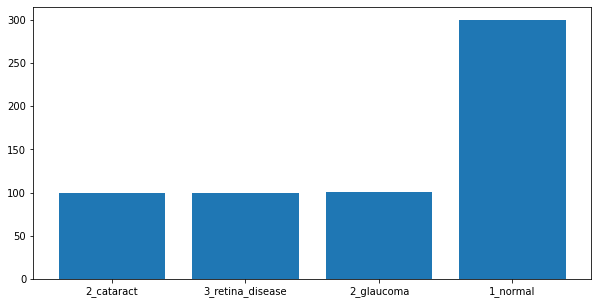

In [60]:
folders = os.listdir(DATA_PATH)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(DATA_PATH + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(folder)

zipped_lists = zip(train_number,class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number,class_num = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(10,5))  
plt.bar(class_num, train_number)
plt.xticks(class_num)
plt.show()

In [61]:
balanced_dataset_folder=r'balanced_dataset'

In [62]:
'''Creating the balance dataset using flipping and rotating'''
c=0
List = os.listdir(DATA_PATH)
# balanced_dataset_folder=r'balanced_dataset'
for x in List:
    folder= balanced_dataset_folder+r'/'+x+r'/'
    if os.path.exists(folder):
        pass
    else:
        os.makedirs(folder)
    path=os.path.join(DATA_PATH,x)
    images_folder = os.listdir(path)
    for images in images_folder:
        image_path = path + '/' + images
        if x == '1_normal':
            image= cv2.imread(image_path)
            cv2.imwrite(folder+x+str(c)+r'_.png', image)
            c+=1
        else:
            image1 = cv2.imread(image_path)
            cv2.imwrite(folder+x+str(c)+r'_.png',image1)
            c+=1
            
            image2 = cv2.flip(image1,1)
            cv2.imwrite(folder+x+str(c)+r'_.png',image2)
            c+=1
            
            image3 = cv2.rotate(image1,cv2.ROTATE_180)
            cv2.imwrite(folder+x+str(c)+r'_.png',image3)
            c+=1
print('Count of total images in balanced dataset is: {}'.format(c))

Count of total images in balanced dataset is: 1203


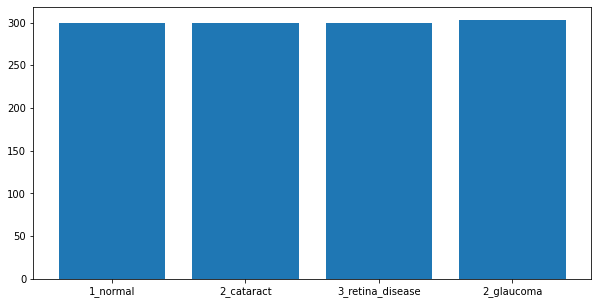

In [63]:
folders = os.listdir(balanced_dataset_folder)
train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(balanced_dataset_folder + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(folder)

zipped_lists = zip(train_number,class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number,class_num = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(10,5))  
plt.bar(class_num, train_number)
plt.xticks(class_num)
plt.show()

In [65]:
'''Initilizing parameters related to images'''
IMAGE_WIDTH= 256
IMAGE_HEIGHT= 256
BATCH_SIZE= 32
CHANNEL= 3
SEED=123
num_classes=4
balanced_dataset_folder=r'balanced_dataset'

In [169]:
'''Defining Dataset'''
dataset=tf.keras.preprocessing.image_dataset_from_directory(balanced_dataset_folder,
                                                           image_size= (IMAGE_WIDTH,IMAGE_HEIGHT),
                                                           shuffle= True,
                                                           batch_size=BATCH_SIZE,
                                                           crop_to_aspect_ratio=True,
                                                           seed=SEED
                                                           )

Found 1203 files belonging to 4 classes.


In [170]:
'''Class Names'''
class_name=dataset.class_names
class_name

['1_normal', '2_cataract', '2_glaucoma', '3_retina_disease']

In [171]:
'''Describimg the Image Batch and Label Batch'''
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 2, 0, 2, 0, 3, 2, 1, 0, 3, 2, 3, 0, 2, 0, 2, 0, 1, 1, 1, 1, 3,
       3, 2, 0, 3, 2, 2, 1, 0, 0, 1])>>


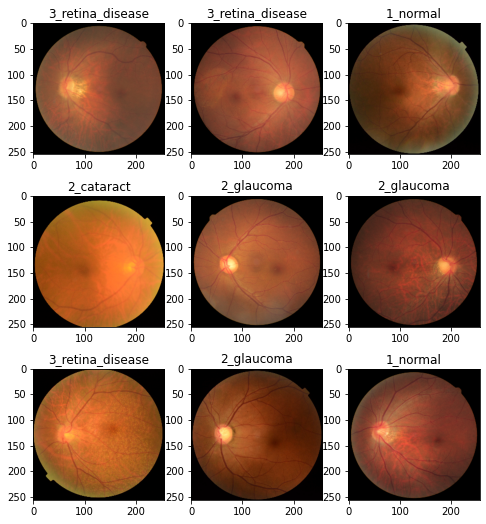

In [172]:
plt.figure(figsize=(8, 9))
for image_batch, label_batch in dataset.take(1):
    for x in range(9):
        ax=plt.subplot(3,3,x+1)
        plt.imshow(image_batch[x].numpy().astype('int'))
        plt.title(class_name[label_batch[x]])
#         plt.axis('off')

In [173]:
'''Dividing dataset into train and validation (80%, 20%)'''

print("Length of 1-batch of dataset: {}".format(len(dataset)))

'''Training dataset'''
train_data_batch=int(len(dataset)*0.80)
train_data=dataset.take(train_data_batch)
print("Length of 1-batch of train data: {}".format(len(train_data)))

'''Testing dataset'''
test_data=dataset.skip(train_data_batch)
print("Length of 1-batch of test data: {}".format(len(test_data)))

Length of 1-batch of dataset: 38
Length of 1-batch of train data: 30
Length of 1-batch of test data: 8


#### ResNet50

In [119]:
'''Creating fuction of teacher model architecture '''
def Teacher_Model(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3)):
    teacher = ResNet50(weights="imagenet", include_top = False, input_shape=input_shape)
    model = Sequential()
    model.add(teacher)
    model.add(Flatten())
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(num_classes,activation="softmax"))
    
    return model

In [120]:
'''Summary of teacher model'''

teacher_model=Teacher_Model()
teacher_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 131072)            0         
                                                                 
 dense_14 (Dense)            (None, 512)               67109376  
                                                                 
 dense_15 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 90,699,140
Trainable params: 90,646,020
Non-trainable params: 53,120
_________________________________________________________________


In [121]:
'''Compilation of teacher model'''
teacher_model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

In [122]:
'''Monitoring teacher model over loss'''
checkpoint= ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [123]:
'''Early Stoping of teacher model to avoid overfitting'''
earlystopping=EarlyStopping(monitor='val_loss', patience=3)

In [124]:
'''Callback defination'''
callback=[checkpoint,earlystopping]

In [125]:
'''Model history'''
history= teacher_model.fit(train_data,batch_size=BATCH_SIZE,epochs= 25, validation_data=test_data)

Epoch 1/25
30/30 [==============================] - 724s 24s/step - loss: 19.8003 - accuracy: 0.3302 - val_loss: 5042.2422 - val_accuracy: 0.2510
Epoch 2/25
30/30 [==============================] - 567s 19s/step - loss: 1.2324 - accuracy: 0.4333 - val_loss: 70.2315 - val_accuracy: 0.2181
Epoch 3/25
30/30 [==============================] - 583s 19s/step - loss: 1.1139 - accuracy: 0.4823 - val_loss: 28.0054 - val_accuracy: 0.2428
Epoch 4/25
30/30 [==============================] - 535s 18s/step - loss: 1.0155 - accuracy: 0.5208 - val_loss: 5.2493 - val_accuracy: 0.3745
Epoch 5/25
30/30 [==============================] - 516s 17s/step - loss: 0.9106 - accuracy: 0.5823 - val_loss: 1.2949 - val_accuracy: 0.5267
Epoch 6/25
30/30 [==============================] - 511s 17s/step - loss: 0.9291 - accuracy: 0.5750 - val_loss: 0.9900 - val_accuracy: 0.5473
Epoch 7/25
30/30 [==============================] - 565s 19s/step - loss: 0.9030 - accuracy: 0.5802 - val_loss: 0.9931 - val_accuracy: 0.5720


In [126]:
'''Evaluating teacher test dataset'''
loss, acc = teacher_model.evaluate(test_data)
print('test loss = ', loss) 
print('test accuracy = ',acc)

8/8 [==============================] - 40s 3s/step - loss: 0.5332 - accuracy: 0.7778
test loss =  0.5331612825393677
test accuracy =  0.7777777910232544


In [200]:
'''Evaluating teacher train dataset'''
loss, acc = teacher_model.evaluate(train_data)
print('train loss = ', loss) 
print('train accuracy = ',acc)

30/30 [==============================] - 141s 5s/step - loss: 0.4508 - accuracy: 0.8219
train loss =  0.45083844661712646
train accuracy =  0.8218749761581421


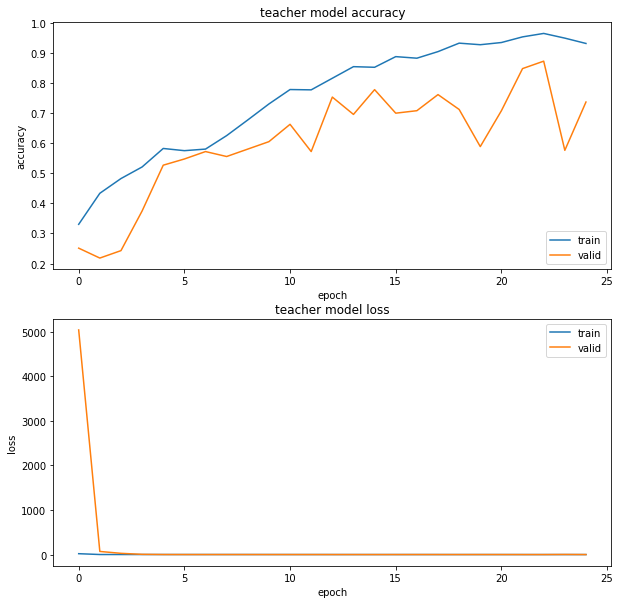

In [128]:
plt.figure(figsize=(10,10))   
'''Summarizing teacher history of accuracy'''
plt.subplot(211)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])
plt.title('teacher model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

'''Summarizing teacher history of loss'''
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('teacher model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

#### Distiller Class Intilization

In [174]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            #Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.S
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#### Student Model With Knowledge Distillation

In [175]:
def Student_model(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3)):
    model=tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='valid',activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='valid',activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='valid',activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=512,activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
    
    return model

In [176]:
'''Summary of student model'''
student_model=Student_model()
student_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_31 (Conv2D)          (None, 254, 254, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_32 (Conv2D)          (None, 127, 127, 64)      18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 64)      36928     
                                                      

In [177]:
'''cloning student model for later comparison'''
student_scratch = tf.keras.models.clone_model(student_model)

#### Distillation/transfering of knowledge from Teacher to Student

In [178]:
'''Intilizing Distiller Class'''
distiller = Distiller(student=student_model, teacher=teacher_model)

In [192]:
'''Compiling student model using distiller class'''
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=100,
)

In [193]:
'''Trasfering teacher information to student'''
distiller_hist=distiller.fit(train_data,batch_size=BATCH_SIZE,epochs= 20, validation_data=test_data)

Epoch 1/20
30/30 [==============================] - 375s 12s/step - accuracy: 0.6844 - student_loss: 0.7319 - distillation_loss: 0.0337 - val_accuracy: 0.6584 - val_student_loss: 0.5773
Epoch 2/20
30/30 [==============================] - 377s 12s/step - accuracy: 0.7031 - student_loss: 0.7345 - distillation_loss: 0.0318 - val_accuracy: 0.6502 - val_student_loss: 0.7531
Epoch 3/20
30/30 [==============================] - 377s 12s/step - accuracy: 0.6938 - student_loss: 0.7118 - distillation_loss: 0.0309 - val_accuracy: 0.7037 - val_student_loss: 0.9458
Epoch 4/20
30/30 [==============================] - 381s 13s/step - accuracy: 0.7396 - student_loss: 0.6886 - distillation_loss: 0.0288 - val_accuracy: 0.6872 - val_student_loss: 0.7039
Epoch 5/20
30/30 [==============================] - 380s 13s/step - accuracy: 0.7177 - student_loss: 0.6908 - distillation_loss: 0.0285 - val_accuracy: 0.7037 - val_student_loss: 0.7292
Epoch 6/20
30/30 [==============================] - 380s 13s/step - ac

In [197]:
'''Evaluating distiller test data'''
acc,loss = distiller.evaluate(test_data)
print('test loss = ', loss) 
print('test accuracy = ',acc)

8/8 [==============================] - 33s 2s/step - accuracy: 0.7654 - student_loss: 0.6248
test loss =  0.7717176675796509
test accuracy =  0.7654321193695068


In [199]:
'''Evaluating distiller train data'''
acc,loss = distiller.evaluate(train_data)
print('train loss = ', loss) 
print('train accuracy = ',acc)

30/30 [==============================] - 138s 4s/step - loss: 0.4400 - accuracy: 0.8240
train loss =  0.44004949927330017
train accuracy =  0.8239583373069763


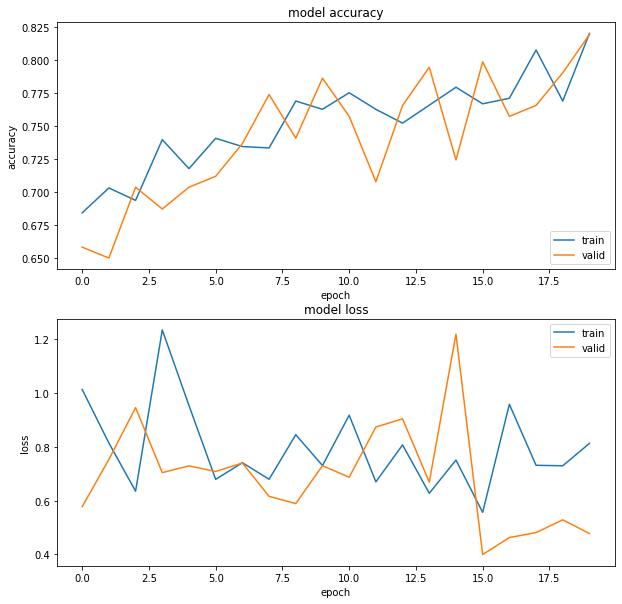

<Figure size 432x288 with 0 Axes>

In [196]:
plt.figure(figsize=(10,10)) 

'''Summarizing distiller history of accuracy'''
plt.subplot(211)  
plt.plot(distiller_hist.history['accuracy'])  
plt.plot(distiller_hist.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='lower right')  

'''Summarizing distiller history of loss'''
plt.subplot(212)  
plt.plot(distiller_hist.history['student_loss'])  
plt.plot(distiller_hist.history['val_student_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='upper right')  
plt.show()
plt.tight_layout()

#### Student Model Without Knowledge Distillation

In [139]:
'''Compiling student model from scratch'''
student_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [140]:
'''Defining Callback'''
checkpoint= ModelCheckpoint('best_model2.h5', monitor='val_loss', save_best_only=True)
callback=[earlystopping,checkpoint]

In [141]:
'''Training student model from scratch'''
student_hist = student_scratch.fit(train_data,batch_size=BATCH_SIZE,epochs= 20, validation_data=test_data)

Epoch 1/20
30/30 [==============================] - 232s 8s/step - loss: 52.6861 - accuracy: 0.2771 - val_loss: 1.3847 - val_accuracy: 0.2963
Epoch 2/20
30/30 [==============================] - 225s 7s/step - loss: 1.3676 - accuracy: 0.3063 - val_loss: 1.3073 - val_accuracy: 0.3004
Epoch 3/20
30/30 [==============================] - 223s 7s/step - loss: 1.2899 - accuracy: 0.3792 - val_loss: 1.2971 - val_accuracy: 0.3539
Epoch 4/20
30/30 [==============================] - 225s 7s/step - loss: 1.2649 - accuracy: 0.3927 - val_loss: 1.2231 - val_accuracy: 0.4074
Epoch 5/20
30/30 [==============================] - 222s 7s/step - loss: 1.2436 - accuracy: 0.4000 - val_loss: 1.2048 - val_accuracy: 0.4321
Epoch 6/20
30/30 [==============================] - 223s 7s/step - loss: 1.2178 - accuracy: 0.4073 - val_loss: 1.1895 - val_accuracy: 0.4568
Epoch 7/20
30/30 [==============================] - 222s 7s/step - loss: 1.2091 - accuracy: 0.4167 - val_loss: 1.2159 - val_accuracy: 0.4156
Epoch 8/20
3

In [142]:
'''Evaluating student test data'''
loss, acc = student_scratch.evaluate(test_data)
print('test loss = ', loss) 
print('test accuracy = ',acc)

8/8 [==============================] - 25s 919ms/step - loss: 1.0236 - accuracy: 0.5267
test loss =  1.0236144065856934
test accuracy =  0.5267489552497864


In [143]:
'''Evaluating student train data'''
loss, acc = student_scratch.evaluate(train_data)
print('train loss = ', loss) 
print('train accuracy = ',acc)

30/30 [==============================] - 46s 1s/step - loss: 0.9907 - accuracy: 0.5677
train loss =  0.9907327890396118
train accuracy =  0.5677083134651184


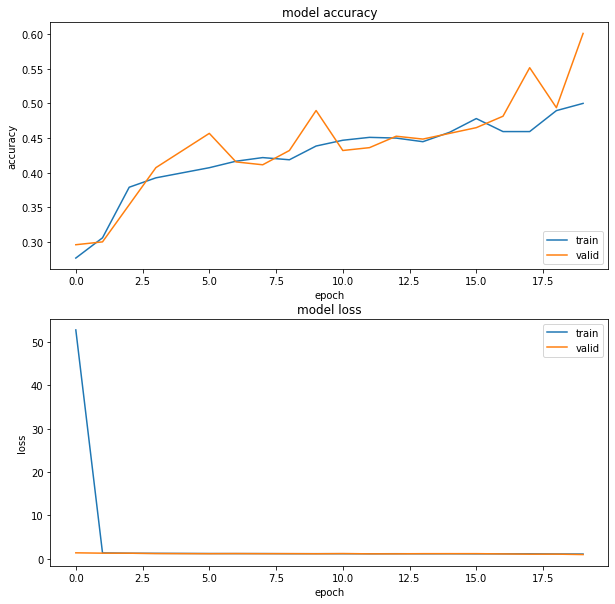

<Figure size 432x288 with 0 Axes>

In [144]:
plt.figure(figsize=(10,10))

'''Summarizing student history of accuracy'''
plt.subplot(211)  
plt.plot(student_hist.history['accuracy'])  
plt.plot(student_hist.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='lower right')  

'''Summarizing student history of loss'''
plt.subplot(212)  
plt.plot(student_hist.history['loss'])  
plt.plot(student_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='upper right')  
plt.show()
plt.tight_layout()

#### Comparison of Models

In [204]:
'''Unbalanced dataset Model'''

dict_Unbalanced = {
                   'Models':['Teacher','Distiller(t=50)','Distiller(t=70)','Distiller(t=90)','Distiller(t=100)','Student'],
                   'Training Accuracy':[0.689,0.497,0.561,0.683,0.979,0.504],
                   'Test Accuracy':[0.691,0.471,0.568,0.719,0.966,0.495]
                  }

In [205]:
'''Structuring of different parameters with accuracy'''
Unbalanced_dataframe = pd.DataFrame(dict_Unbalanced)
Unbalanced_dataframe

,Models,Training Accuracy,Test Accuracy
0,Teacher,0.689,0.691
1,Distiller(t=50),0.497,0.471
2,Distiller(t=70),0.561,0.568
3,Distiller(t=90),0.683,0.719
4,Distiller(t=100),0.979,0.966
5,Student,0.504,0.495


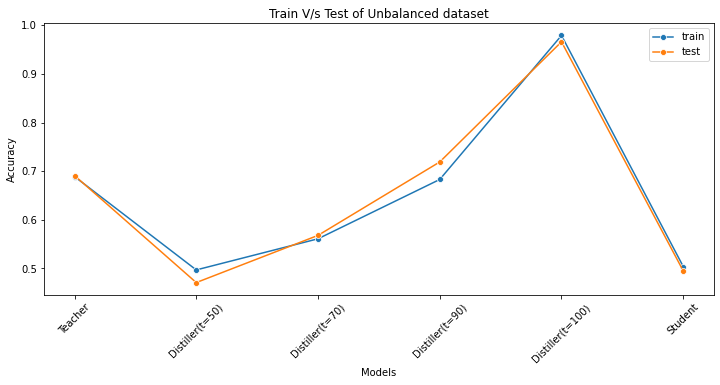

In [255]:
'''Visulization of Models with respect to each other'''
plt.figure(figsize=(12,5))
ax=sns.lineplot(x='Models',y='Training Accuracy',data=Unbalanced_dataframe,marker='o')
ax=sns.lineplot(x='Models',y='Test Accuracy',data=Unbalanced_dataframe, marker='o')
ax.set_title('Train V/s Test of Unbalanced dataset')
ax.set_ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper right')
ax.set_xticklabels(labels=['Teacher','Distiller(t=50)','Distiller(t=70)','Distiller(t=90)','Distiller(t=100)','Student'],
                   rotation=45)
plt.show()

In [256]:
'''Balanced dataset Model'''

dict_balanced = {
                   'Models':['Teacher','Distiller(t=50)','Distiller(t=70)','Distiller(t=90)','Distiller(t=100)','Student'],
                   'Training Accuracy':[0.821,0.535,0.610,0.710,0.823,0.567],
                   'Test Accuracy':[0.777,0.514,0.609,0.637,0.765,0.526]
                  }

In [245]:
'''Structuring of different parameters with accuracy'''
Balanced_dataframe = pd.DataFrame(dict_balanced)
Balanced_dataframe

,Models,Training Accuracy,Test Accuracy
0,Teacher,0.821,0.777
1,Distiller(t=50),0.535,0.514
2,Distiller(t=70),0.610,0.609
3,Distiller(t=90),0.710,0.637
4,Distiller(t=100),0.823,0.765
5,Student,0.567,0.526


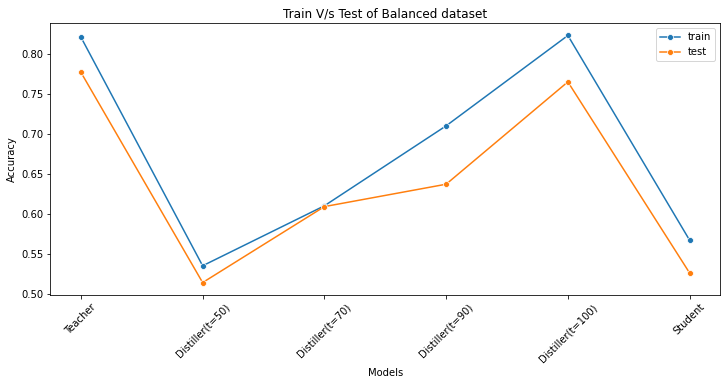

In [251]:
'''Visulization of Models with respect to each other'''
plt.figure(figsize=(12,5))
ax=sns.lineplot(x='Models',y='Training Accuracy',data=Balanced_dataframe,marker='o')
ax=sns.lineplot(x='Models',y='Test Accuracy',data=Balanced_dataframe, marker='o')
ax.set_title('Train V/s Test of Balanced dataset')
ax.set_ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper right')
ax.set_xticklabels(labels=['Teacher','Distiller(t=50)','Distiller(t=70)','Distiller(t=90)','Distiller(t=100)','Student'],
                   rotation=45)
plt.show()

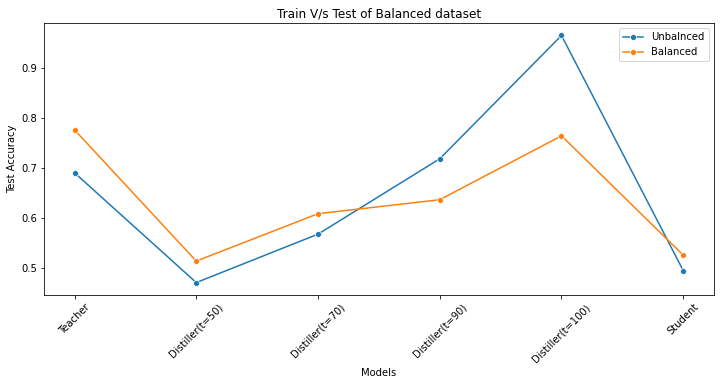

In [252]:
'''Comparison between testing accuracy of balanced and unbalanced datasets'''
plt.figure(figsize=(12,5))
ax=sns.lineplot(x='Models',y='Test Accuracy',data=Unbalanced_dataframe,marker='o')
ax=sns.lineplot(x='Models',y='Test Accuracy',data=Balanced_dataframe, marker='o')
ax.set_title('Train V/s Test of Balanced dataset')
ax.set_ylabel('Test Accuracy')
plt.legend(['Unbalnced', 'Balanced'], loc='upper right')
ax.set_xticklabels(labels=['Teacher','Distiller(t=50)','Distiller(t=70)','Distiller(t=90)','Distiller(t=100)','Student'],
                   rotation=45)
plt.show()